#Predição do Bitcoin com RNN

###Esse projeto tem como objetivo construir um modelo que prevê os valores futuros de Bitcoin do dataset abaixo:
https://www.kaggle.com/mczielinski/bitcoin-historical-data

###Esse dataset contêm os valores de transações de Bitcoin de minuto a minuto desde 01/01/2012 até 22/04/2020, com as seguintes colunas:
- Timestamp (começo da janela de tempo de um minuto em horário Unix)
- Open (preço inicial)
- High (maior preço)
- Low (menor preço)
- Close (preço final)
- Volume_(BTC) (quantidade de Bitcoin transacionado)
- Volume_(Currency) (quantidade de moeda transacionado)
- Weighted_Price (preço médio)

Usaremos a variavel Timestamp para sequênciar os valores e tentaremos predizer a variável Weighted_Price.

In [1]:
from google.colab import drive
drive.mount('/content/drive')
caminho_drive = '/content/drive/My Drive/colab/RNN/'

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


Primeiro vamos importar as bibliotecas que usaremos durante todo o notebook.

In [0]:
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime, timezone
from sklearn.preprocessing import MinMaxScaler
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dropout, Dense

Agora importamos o arquivo para começar a análise.

In [0]:
nm_arquivo = 'bitstampUSD_1-min_data_2012-01-01_to_2020-04-22.csv'
arquivo = pd.read_csv( caminho_drive + nm_arquivo )

In [4]:
arquivo.describe()

,Timestamp,Open,High,Low,Close,Volume_(BTC),Volume_(Currency),Weighted_Price
count,4.363457e+06,3.126480e+06,3.126480e+06,3.126480e+06,3.126480e+06,3.126480e+06,3.126480e+06,3.126480e+06
mean,1.456469e+09,3.674656e+03,3.677366e+03,3.671730e+03,3.674595e+03,9.855040e+00,2.884459e+04,3.674570e+03
std,7.573296e+07,3.935578e+03,3.939077e+03,3.931713e+03,3.935490e+03,3.229272e+01,1.010277e+05,3.935458e+03
min,1.325318e+09,3.800000e+00,3.800000e+00,1.500000e+00,1.500000e+00,0.000000e+00,0.000000e+00,3.800000e+00
25%,1.390770e+09,4.100000e+02,4.102400e+02,4.098300e+02,4.100000e+02,3.988120e-01,3.503759e+02,4.099998e+02
50%,1.456610e+09,1.175140e+03,1.175770e+03,1.174825e+03,1.175140e+03,1.990000e+00,2.620491e+03,1.175200e+03
75%,1.522062e+09,6.931175e+03,6.935780e+03,6.926790e+03,6.931225e+03,7.639098e+00,1.760057e+04,6.931180e+03
max,1.587514e+09,1.966576e+04,1.966600e+04,1.964996e+04,1.966575e+04,5.853852e+03,7.569437e+06,1.966330e+04


In [5]:
arquivo.head()

,Timestamp,Open,High,Low,Close,Volume_(BTC),Volume_(Currency),Weighted_Price
0,1325317920,4.39,4.39,4.39,4.39,0.455581,2.0,4.39
1,1325317980,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1325318040,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1325318100,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1325318160,NaN,NaN,NaN,NaN,NaN,NaN,NaN


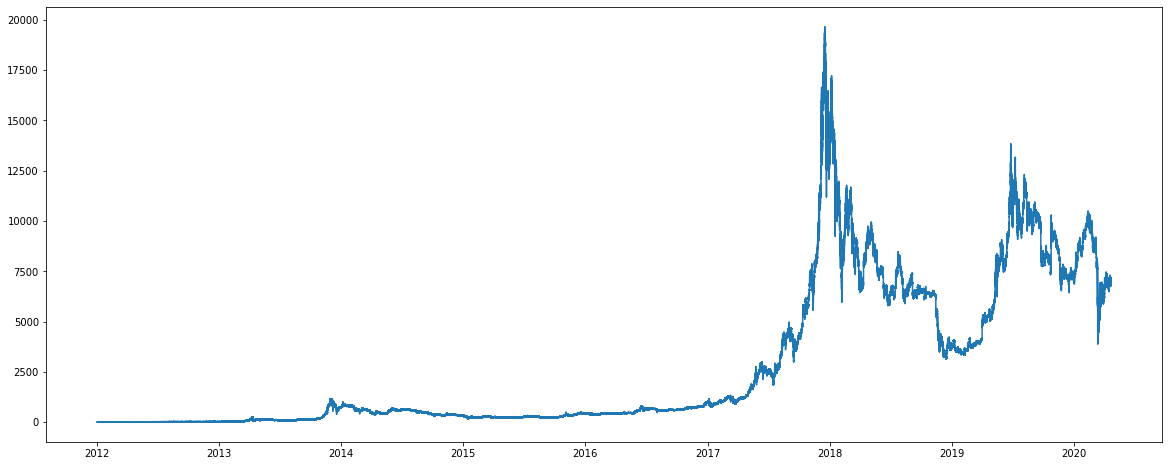

In [6]:
x_plot = pd.to_datetime(arquivo['Timestamp'], unit='s')

plt.figure( figsize=(20, 8) )
plt.plot( x_plot, arquivo['Weighted_Price'] )

Primeira coisa que podemos perceber é que antes de 2017 temos muitos valores NaN, que significa que não tinhamos muitas transações da moeda. Vamos então filtrar esses dados com intuito de trabalharmos com os dados mais voláteis.

In [0]:
dt = datetime(2019, 1, 1)
timestamp = dt.replace(tzinfo=timezone.utc).timestamp()

arquivo_maior_2017 = arquivo[ arquivo['Timestamp'] >= timestamp ]

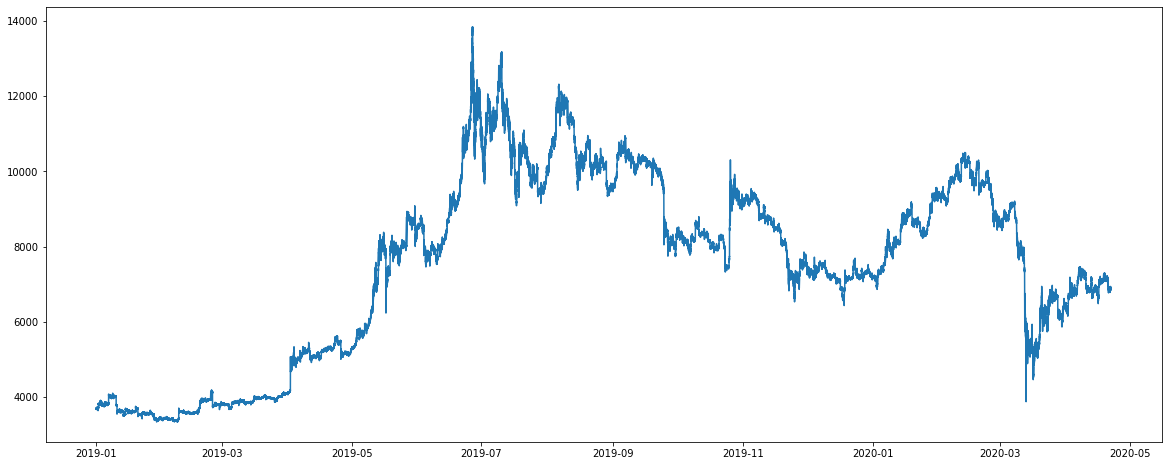

In [8]:
x_plot = pd.to_datetime(arquivo_maior_2017['Timestamp'], unit='s')

plt.figure( figsize=(20, 8) )
plt.plot( x_plot, arquivo_maior_2017['Weighted_Price'] )

In [9]:
arquivo_maior_2017.isna().sum()

Timestamp                0
Open                 18910
High                 18910
Low                  18910
Close                18910
Volume_(BTC)         18910
Volume_(Currency)    18910
Weighted_Price       18910
dtype: int64

Mesmo tirando o ano de 2017, ainda temos muitos casos NaN. Uma linha de Nan significa que não teve nenhuma transação na janela de tempo indicada, ou seja, o valor continuou igual, logo, uma ideia para preencher os valores vazios é de preencher todos os valores com o Close da última linha.


In [10]:
arquivo_maior_2017.sort_values( by=['Timestamp'] ) #garantido a seqência dos valores
arquivo_na = arquivo_maior_2017.copy()

for i in range( arquivo_maior_2017.shape[0] ):
    if (i % 100000 == 0):
        print( '{}/{} dados processados'.format( i, arquivo_maior_2017.shape[0] ) )
    if pd.isna( arquivo_maior_2017.iloc[i][1] ):
        valor_close = arquivo_na.iloc[i - 1][4]
        arquivo_na.iloc[i] = [ arquivo_na.iloc[i][0] , valor_close , valor_close , valor_close , valor_close , 0 , 0 , valor_close ]

0/686881 dados processados
100000/686881 dados processados
200000/686881 dados processados
300000/686881 dados processados
400000/686881 dados processados
500000/686881 dados processados
600000/686881 dados processados


In [11]:
arquivo_na.isna().sum()

Timestamp            0
Open                 0
High                 0
Low                  0
Close                0
Volume_(BTC)         0
Volume_(Currency)    0
Weighted_Price       0
dtype: int64

Olhando a página do dataset o autor diz que podem ter timestamps que não existem, que no momento da janela de tempo, a API que captura os arquivos não estava funcionando. Vamos ver se é muito grande essa quantidade.

In [12]:
valor_minimo = arquivo_na['Timestamp'].min()
valor_maximo = arquivo_na['Timestamp'].max()

quantidade_desejada = int( ( valor_maximo - valor_minimo ) / 60 ) + 1
quantidade_real = arquivo_na.shape[0]

diferenca = quantidade_desejada - quantidade_real
diference_percentual = (diferenca / quantidade_desejada) * 100

print('São {0} linhas não existentes em {1} linhas'.format(diferenca, quantidade_desejada))

São 0 linhas não existentes em 686881 linhas


Como podemos ver, depois de 2017 não temos casos que a API não estava funcionando, então não precisamos nos preocupar.

Vamos agora decidir nossas variaveis da RNN.

Como ainda temos muito dados, podemos usar um numero de time steps grande (tomando cuidado para não deixar grande demais a ponto de estourar a RAM do Colab) e vamos utilizar todos os dados do arquivo, com objetivo de tentar uma boa predição.

As transações de Bitcoin são feitas com uma demora de em média 10 minutos, com isso, devemos tentar predizer valores com pelo menos 10 minutos a frente, ou seja, o nosso future_steps deve ser >= 10.

In [0]:
time_steps = 60
nr_features = arquivo_na.shape[1] - 1 #tiramos a variável de tempo
future_steps = 10

Agora podemos preparar os dados que vão entrar no modelo.

Primeiro vamos normalizar os dados, deixando todos eles com valores entre 0 e 1.

In [14]:
scaler = MinMaxScaler()

arquivo_np = arquivo_na[  arquivo_na.columns[1:] ].to_numpy() #pega todas as colunas, menos a de data, e transforma em uma array

dados_norm = scaler.fit_transform( arquivo_np )

dados_norm

array([[3.42087126e-02, 3.34795916e-02, 3.53696801e-02, ...,
        5.69685282e-03, 2.68199026e-03, 3.44280635e-02],
       [3.42914181e-02, 3.30932192e-02, 3.50651464e-02, ...,
        9.85578533e-03, 4.63446166e-03, 3.40117334e-02],
       [3.38170497e-02, 3.26195096e-02, 3.46816243e-02, ...,
        1.00212655e-03, 4.70625649e-04, 3.35628422e-02],
       ...,
       [3.33911638e-01, 3.33336814e-01, 3.35351503e-01, ...,
        7.35454815e-03, 6.41171710e-03, 3.34165227e-01],
       [3.34641728e-01, 3.33102333e-01, 3.36128064e-01, ...,
        1.26885513e-05, 1.10750117e-05, 3.34936588e-01],
       [3.34301400e-01, 3.32686531e-01, 3.35787367e-01, ...,
        1.49766548e-05, 1.30652920e-05, 3.34594403e-01]])

Agora vamos coloca-los no formato certo para entrar no modelo, onde cada exemplo de X terá (time_steps) linhas e (nr_features) colunas.

In [15]:
qnt_total = len(dados_norm)

X = []
Y = []

for i in range (time_steps, qnt_total - future_steps):
    X.append(dados_norm[i - time_steps : i])
    Y.append(dados_norm[i : i + future_steps , -1])

X_array = np.array( X )
Y_array = np.array( Y )

print('Dimensão de X = {}'.format( X_array.shape ))
print('Dimensão de Y = {}'.format( Y_array.shape ))

Dimensão de X = (686811, 60, 7)
Dimensão de Y = (686811, 10)


In [16]:
X[0]

array([[3.42087126e-02, 3.34795916e-02, 3.53696801e-02, 3.46120456e-02,
        5.69685282e-03, 2.68199026e-03, 3.44280635e-02],
       [3.42914181e-02, 3.30932192e-02, 3.50651464e-02, 3.39131485e-02,
        9.85578533e-03, 4.63446166e-03, 3.40117334e-02],
       [3.38170497e-02, 3.26195096e-02, 3.46816243e-02, 3.35299437e-02,
        1.00212655e-03, 4.70625649e-04, 3.35628422e-02],
       [3.41136488e-02, 3.29156968e-02, 3.48434078e-02, 3.40747982e-02,
        3.07767422e-04, 1.44689850e-04, 3.39367705e-02],
       [3.40661169e-02, 3.28682309e-02, 3.50356447e-02, 3.38836712e-02,
        1.15800524e-04, 5.44380552e-05, 3.39178831e-02],
       [3.38807424e-02, 3.27258332e-02, 3.50413547e-02, 3.39321661e-02,
        2.33181674e-03, 1.09590804e-03, 3.38269730e-02],
       [3.37105782e-02, 3.25131860e-02, 3.47254011e-02, 3.35736842e-02,
        1.61457502e-03, 7.58155333e-04, 3.35199581e-02],
       [3.33284217e-02, 3.22198468e-02, 3.44884358e-02, 3.33540308e-02,
        8.53818455e-04, 4

In [17]:
Y[0]

array([0.0341249 , 0.03419887, 0.03395274, 0.03390981, 0.03390981,
       0.03392899, 0.03402929, 0.03393551, 0.03365475, 0.03376605])

Agora vamos dividir os dados em treino, validação e teste.

In [18]:
porc_treino = 0.7
porc_validacao = 0.15
porc_teste = 0.15

qnt_treino = int( qnt_total * porc_treino )
qnt_validacao = int( qnt_total * porc_validacao )
qnt_teste = int( qnt_total * porc_teste )

X_treino = X_array[ : qnt_treino ]
X_validacao = X_array[ qnt_treino : qnt_treino + qnt_validacao ]
X_teste = X_array[ qnt_treino + qnt_validacao : ]

Y_treino = Y_array[ : qnt_treino ]
Y_validacao = Y_array[ qnt_treino : qnt_treino + qnt_validacao ]
Y_teste = Y_array[ qnt_treino + qnt_validacao : ]

print('{} dados no total'.format( qnt_total ))
print('{} dados para o treino'.format( X_treino.shape[0] ))
print('{} dados para a validação'.format( X_validacao.shape[0] ))
print('{} dados para o teste'.format( X_teste.shape[0] ))

686881 dados no total
480816 dados para o treino
103032 dados para a validação
102963 dados para o teste


Podemos agora ir para o nosso modelo.

In [0]:
model = Sequential()

model.add( LSTM(units=30, input_shape=(time_steps, nr_features)) )
#model.add( LSTM(units=30, input_shape=(time_steps, nr_features), return_sequences=True) )

#model.add( LSTM(units=20, return_sequences=True) )

#model.add( LSTM(units=10) )

model.add( Dense(units=future_steps) )

model.compile(optimizer='adam', loss='mean_squared_error', metrics=['accuracy'])

Com os dados preparados e o modelo criado, podemos agora começar o treino. Vamos utilizar 100 epocas para ver sua performance e tirar ideias disso.

In [20]:
historico = model.fit(X_treino, Y_treino, epochs=100, batch_size=time_steps, validation_data=(X_validacao, Y_validacao), shuffle=False)

Epoch 1/100
8014/8014 [==============================] - 186s 23ms/step - loss: 1.0544e-04 - accuracy: 0.0880 - mse: 1.0544e-04 - val_loss: 0.0065 - val_accuracy: 0.0861 - val_mse: 0.0065
Epoch 2/100
8014/8014 [==============================] - 194s 24ms/step - loss: 1.5047e-04 - accuracy: 0.0981 - mse: 1.5047e-04 - val_loss: 0.0062 - val_accuracy: 0.0857 - val_mse: 0.0062
Epoch 3/100
8014/8014 [==============================] - 193s 24ms/step - loss: 1.4790e-04 - accuracy: 0.0915 - mse: 1.4790e-04 - val_loss: 0.0060 - val_accuracy: 0.0852 - val_mse: 0.0060
Epoch 4/100
8014/8014 [==============================] - 190s 24ms/step - loss: 1.4351e-04 - accuracy: 0.0912 - mse: 1.4351e-04 - val_loss: 0.0059 - val_accuracy: 0.0851 - val_mse: 0.0059
Epoch 5/100
8014/8014 [==============================] - 187s 23ms/step - loss: 1.3403e-04 - accuracy: 0.0956 - mse: 1.3403e-04 - val_loss: 0.0056 - val_accuracy: 0.0851 - val_mse: 0.0056
Epoch 6/100
8014/8014 [==============================] - 186

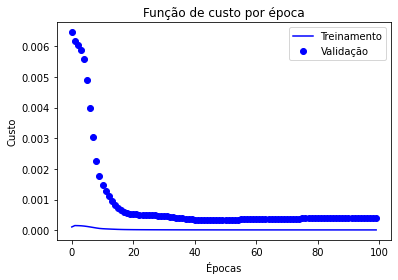

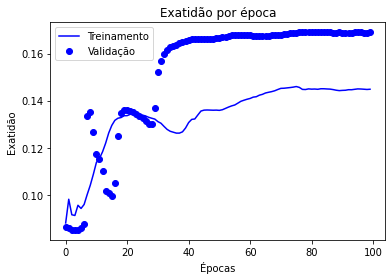

In [22]:
plt.plot(historico.history['loss'], 'b', label='Treinamento')
plt.plot(historico.history['val_loss'], 'bo', label='Validação')
plt.title('Função de custo por época')
plt.xlabel('Épocas')
plt.ylabel('Custo')
plt.legend()
plt.show()

plt.plot(historico.history['accuracy'], 'b', label='Treinamento')
plt.plot(historico.history['val_accuracy'], 'bo', label='Validação')
plt.title('Exatidão por época')
plt.xlabel('Épocas')
plt.ylabel('Exatidão')
plt.legend()
plt.show()